python 3.6.13

keras 2.6.0

tensorflow 2.6.2

任务：基于zgpa_train.csv数据,建立RNN模型,预测股价

1.完成数据预处理，将序列数据转化为可用于RNN输入的数据

2.对新数据zgpa_test.csv进行预测，可视化结果

3.存储预测结果，并观察局部预测结果

备注：模型结构：单层RNN，输出有5个神经元，每次使用前8个数据预测第9个数据

# 数据准备

In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv('zgpa_train.csv')
data.head()

,date,open,high,low,close,volume
0,2016-01-04,30.57,30.57,28.63,28.78,70997200
1,2016-01-05,28.41,29.54,28.23,29.23,87498504
2,2016-01-06,29.03,29.39,28.73,29.26,48012112
3,2016-01-07,28.73,29.25,27.73,28.50,23647604
4,2016-01-08,28.73,29.18,27.63,28.67,98239664


- date,open,high,volume 分别表示日期，开盘价，最高价，交易量（无需使用）

- 关注 close 收盘价

In [2]:
# 加载收盘价
price = data.loc[:, 'close']
price.head()

0    28.78
1    29.23
2    29.26
3    28.50
4    28.67
Name: close, dtype: float64

In [3]:
# 归一化处理
price_norm = price/max(price)
print(price_norm)

0      0.383273
1      0.389266
2      0.389666
3      0.379545
4      0.381808
         ...   
726    0.751099
727    0.750566
728    0.738447
729    0.733120
730    0.722466
Name: close, Length: 731, dtype: float64


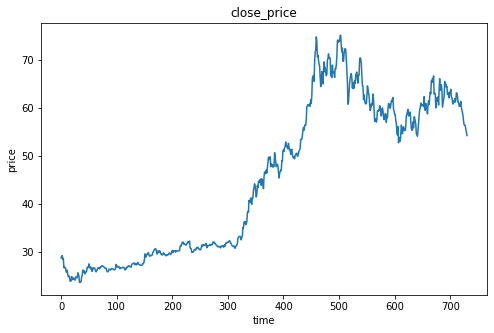

In [4]:
# 归一化之前的数据可视化
%matplotlib inline
from matplotlib import pyplot as plt
fig1 = plt.figure(figsize=(8,5))
plt.plot(price)
plt.title('close_price')  # 归一化之前的数据
plt.xlabel('time')
plt.ylabel('price')
plt.show()

In [5]:
# 对 X 与 y 进行赋值
# 定义方法去提取 X 与 y
def extract_data(data, time_step):
  X = []  # list
  y = []  # list
  # 例如，10个样本；time_step=8；
  # 第一组样本，0,1,2,...7
  # 第二组样本，1,2,3,...8
  # 第三组样本，2,3,4,...9
  # 共有2组样本可供观测
  for i in range(len(data)-time_step):
    X.append([a for a in data[i:i+time_step]])
    y.append(data[i+time_step])
  X = np.array(X)
  X = X.reshape(X.shape[0], X.shape[1], 1)
  return X, y

In [6]:
# 定义 X 与 y
time_step = 8
X, y = extract_data(price_norm, time_step)
print(X.shape) # 723个样本，每个样本有8个数据，每个样本对应1个单独数值，（723,8,1）
print(X[0, :, :]) # 第一个样本数据

(723, 8, 1)
[[0.38327341]
 [0.38926621]
 [0.38966573]
 [0.37954455]
 [0.3818085 ]
 [0.35637235]
 [0.35876948]
 [0.35583966]]


# 模型建立

In [7]:
from keras.models import Sequential        
from keras.layers import Dense, SimpleRNN  # 引入层相关,输出层与 RNN 层

model = Sequential() # 创建实例
model.add(SimpleRNN(units=5, input_shape=(time_step, 1), activation='relu')) # RNN 层
model.add(Dense(units=1, activation='linear')) # 输出层，回归任务直接使用 linear 激活函数
model.compile(optimizer='adam', loss='mean_squared_error') # 回归使用mse评测
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 5)                 35        
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [8]:
# 训练模型
model.fit(X, np.array(y), batch_size = 30, epochs = 200)

Epoch 1/200
25/25 [==============================] - 4s 41ms/step - loss: 0.9976
Epoch 2/200
25/25 [==============================] - 1s 31ms/step - loss: 0.3583
Epoch 3/200
25/25 [==============================] - 1s 41ms/step - loss: 0.1494
Epoch 4/200
25/25 [==============================] - 1s 34ms/step - loss: 0.0812
Epoch 5/200
25/25 [==============================] - 1s 34ms/step - loss: 0.0347
Epoch 6/200
25/25 [==============================] - 1s 31ms/step - loss: 0.0156
Epoch 7/200
25/25 [==============================] - 1s 38ms/step - loss: 0.0122
Epoch 8/200
25/25 [==============================] - 1s 33ms/step - loss: 0.0117: 0s - loss:
Epoch 9/200
25/25 [==============================] - 1s 32ms/step - loss: 0.0113
Epoch 10/200
25/25 [==============================] - 1s 31ms/step - loss: 0.0108
Epoch 11/200
25/25 [==============================] - 1s 33ms/step - loss: 0.0104
Epoch 12/200
25/25 [==============================] - 1s 31ms/step - loss: 0.0099
Epoch 13/200


In [9]:
# 基于训练数据做预测
y_train_predict = model.predict(X)*max(price) # 预测结果：去除归一化
y_train = [i * max(price) for i in y] # 训练数据真实结果

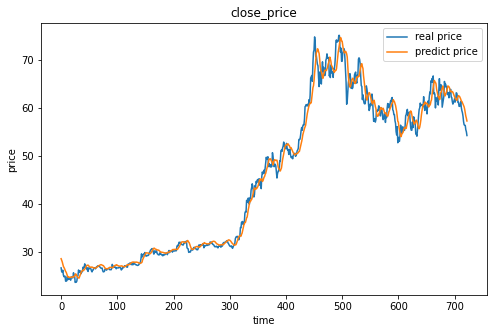

In [10]:
fig2 = plt.figure(figsize=(8, 5))
plt.plot(y_train, label='real price')
plt.plot(y_train_predict, label='predict price')
plt.title('close_price')  # 归一化之前的数据
plt.xlabel('time')
plt.ylabel('price')
plt.legend()
plt.show()

In [12]:
# 对测试数据局进行预测
data_test = pd.read_csv('zgpa_test.csv')
data_test.head()
price_test = data_test.loc[:, 'close']
price_test.head()

# extract X_test and y_test
price_test_norm = price_test/max(price)
X_test_norm, y_test_norm = extract_data(price_test_norm, time_step)
print(X_test_norm.shape, len(y_test_norm))

(12, 8, 1) 12


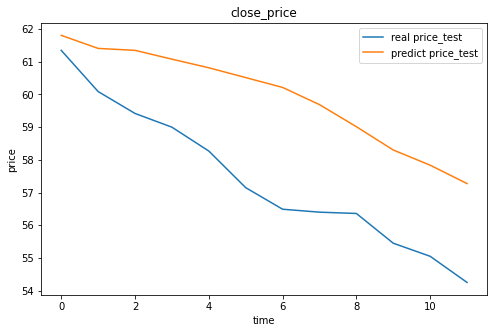

In [13]:
# make prediction based on the test data
y_test_predict = model.predict(X_test_norm)*max(price)
y_test = [i*max(price) for i in y_test_norm]

fig3 = plt.figure(figsize=(8, 5))
plt.plot(y_test, label='real price_test')
plt.plot(y_test_predict, label='predict price_test')
plt.title('close_price')  # 归一化之前的数据
plt.xlabel('time')
plt.ylabel('price')
plt.legend()
plt.show()


In [16]:
# 存储数据
result_y_test = np.array(y_test).reshape(-1, 1) # 若干行，1列
result_y_test_predict = y_test_predict
print(result_y_test.shape, result_y_test_predict.shape)
result = np.concatenate((result_y_test, result_y_test_predict), axis=1)
print(result.shape)
result = pd.DataFrame(result, columns=['real_price_test', 'predict_price_test'])
result.to_csv('zgpa_predict_test.csv')

(12, 1) (12, 1)
(12, 2)


局限性：预测结果比实际结果趋势变化较慢